In this file, we recreate the experiment done by Lorenz et Coecke, but rewrite them using Lambeq. 
Then, using DisCoPy methods, we extract the trained circuit parameters to see to what extent they are storing semantics. 
The training pipelines as well as the code used in this file are taken from and inspired by the code available on the official Lambeq website: 
https://docs.quantinuum.com/lambeq/index.html
In this file, we train three different models using three different pipelines from the above website. 
We then save the parameters (weights) learned by the models in the training process, as well as measures like, e.g., the accuracy to plot in separate files. 

In [53]:
# Import all kinds of lambeq stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt   
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

In [54]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 500
SEED = 2

LEARNING_RATE = 3e-2

NQ = 1
GIJS = True

In [55]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


# note that words labelled with '1', receive the label  |0> = [1,0]

train_labels, forget = read_data('../datasets/mc_train_data.txt')
test_labels, forget = read_data('../datasets/mc_test_data.txt')
val_labels, forget = read_data('../datasets/mc_dev_data.txt')


# here, we can choose between either the original dataset by Coecke et al. or the new one for Gijs' data

if not GIJS: 
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/newTestSentences.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/newTrainSentences.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/newValSentences.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


if GIJS:
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/testGijs.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/trainGijs.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/valGijs.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]




In [56]:
print(len(test_data))
print(len(train_data))
print(len(val_data))

print(test_labels)

30
70
30
[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]


In [57]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [58]:
# normalising 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]



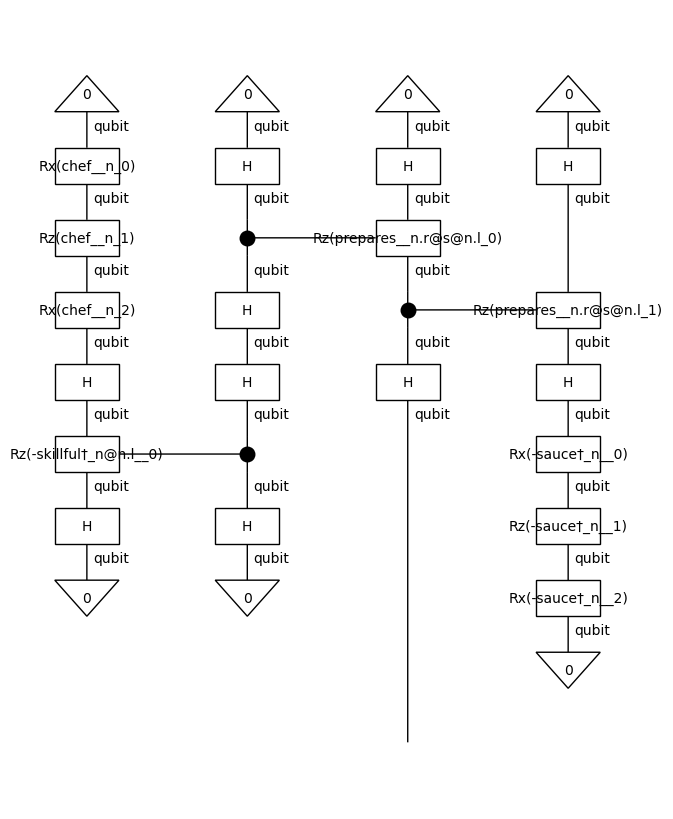

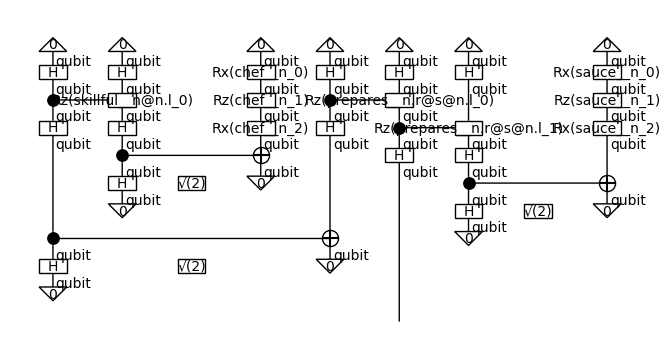

In [87]:
# create quantum circuits

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

ansatz(raw_train_diagrams[0]).draw()


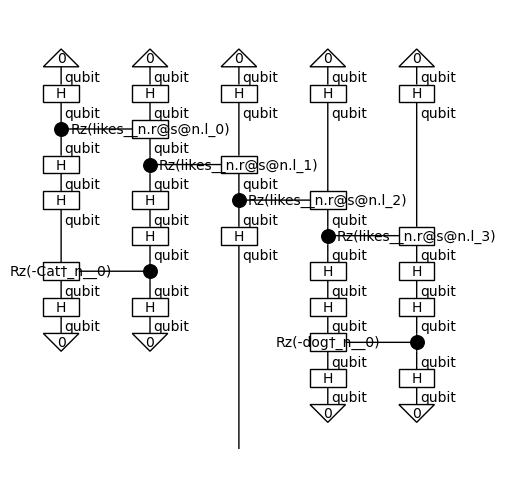

In [60]:
test = parser.sentence2diagram('Cat likes dog')
test = remove_cups(test)
testt = ansatz(test)
testt.draw()

In [61]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + val_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
modelPennylane = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
modelPennylane.initialise_weights()



In [62]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)
                          
val_dataset = Dataset(val_circuits, val_labels)

In [63]:
def accPL(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

import torch



# these two metrics, I want to evaluate the models on. I want to save the score for every model. 
from sklearn.metrics import f1_score

from sklearn.metrics import cohen_kappa_score




In [64]:
from lambeq import PytorchTrainer
import torch

trainerPennylane = PytorchTrainer(
    model=modelPennylane,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': accPL},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [65]:
# trainer.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

trainerPennylane.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.2002   valid/loss: 0.2074   train/acc: 0.7143   valid/acc: 0.6333
Epoch 2:    train/loss: 0.0400   valid/loss: 0.1209   train/acc: 0.8857   valid/acc: 0.8667
Epoch 3:    train/loss: 0.0310   valid/loss: 0.0922   train/acc: 0.9143   valid/acc: 0.8667
Epoch 4:    train/loss: 0.0762   valid/loss: 0.0822   train/acc: 0.9571   valid/acc: 0.8667
Epoch 5:    train/loss: 0.0622   valid/loss: 0.0797   train/acc: 0.9714   valid/acc: 0.9000
Epoch 6:    train/loss: 0.1253   valid/loss: 0.0788   train/acc: 0.9714   valid/acc: 0.9000
Epoch 7:    train/loss: 0.0170   valid/loss: 0.0635   train/acc: 0.9714   valid/acc: 0.9333
Epoch 8:    train/loss: 0.0110   valid/loss: 0.0484   train/acc: 0.9857   valid/acc: 0.9333
Epoch 9:    train/loss: 0.0108   valid/loss: 0.0494   train/acc: 1.0000   valid/acc: 0.9333
Epoch 10:   train/loss: 0.0330   valid/loss: 0.0400   train/acc: 0.9857   valid/acc: 0.9333
Epoch 11:   train/loss: 0.0598   valid/loss: 0.0278   train/acc: 0.9714   valid/

In [66]:
# Do the same thing, but now using the NUMPY model! 

from lambeq import NumpyModel

modelNumpy = NumpyModel.from_diagrams(all_circuits, use_jit=False)


from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

accNP = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": accNP}


# NUMPY model uses QuantumTrainer class 

from lambeq import QuantumTrainer, SPSAOptimizer

trainerNumpy = QuantumTrainer(
    modelNumpy,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)




In [67]:
# train the numpy model 

trainerNumpy.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 1.0131   valid/loss: 1.1573   train/acc: 0.4857   valid/acc: 0.4667
Epoch 2:    train/loss: 1.4839   valid/loss: 0.9769   train/acc: 0.6000   valid/acc: 0.6667
Epoch 3:    train/loss: 1.5191   valid/loss: 0.6540   train/acc: 0.5857   valid/acc: 0.6667
Epoch 4:    train/loss: 1.0604   valid/loss: 0.6590   train/acc: 0.5143   valid/acc: 0.6000
Epoch 5:    train/loss: 0.7726   valid/loss: 0.7743   train/acc: 0.5714   valid/acc: 0.5667
Epoch 6:    train/loss: 0.7508   valid/loss: 0.6855   train/acc: 0.6286   valid/acc: 0.5000
Epoch 7:    train/loss: 0.5284   valid/loss: 0.7638   train/acc: 0.6286   valid/acc: 0.5000
Epoch 8:    train/loss: 0.7771   valid/loss: 0.7416   train/acc: 0.6857   valid/acc: 0.5667
Epoch 9:    train/loss: 0.7580   valid/loss: 0.7865   train/acc: 0.6429   valid/acc: 0.5000
Epoch 10:   train/loss: 0.4585   valid/loss: 0.6062   train/acc: 0.6714   valid/acc: 0.5667
Epoch 11:   train/loss: 0.7424   valid/loss: 0.5962   train/acc: 0.6714   valid/

In [68]:
'''
Same thing, but for Tket model 
'''

from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

modelTK = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bceTK = BinaryCrossEntropyLoss()

accTK = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metricsTK = {"acc": accTK}

from lambeq import QuantumTrainer, SPSAOptimizer

trainerTK = QuantumTrainer(
    modelTK,
    loss_function=bceTK,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metricsTK,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)


trainerTK.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 1.5820   valid/loss: 2.5629   train/acc: 0.5357   valid/acc: 0.7333
Epoch 2:    train/loss: 0.3765   valid/loss: 2.6641   train/acc: 0.6786   valid/acc: 0.6000
Epoch 3:    train/loss: 5.6037   valid/loss: 1.8197   train/acc: 0.6643   valid/acc: 0.6333
Epoch 4:    train/loss: 1.7003   valid/loss: 1.2857   train/acc: 0.5357   valid/acc: 0.6000
Epoch 5:    train/loss: 0.3412   valid/loss: 1.0509   train/acc: 0.6643   valid/acc: 0.7500
Epoch 6:    train/loss: 3.9636   valid/loss: 2.3130   train/acc: 0.5786   valid/acc: 0.3500
Epoch 7:    train/loss: 9.7410   valid/loss: 3.2644   train/acc: 0.4786   valid/acc: 0.5167
Epoch 8:    train/loss: 4.8198   valid/loss: 1.9105   train/acc: 0.6000   valid/acc: 0.6000
Epoch 9:    train/loss: 2.8002   valid/loss: 2.6646   train/acc: 0.5286   valid/acc: 0.6667
Epoch 10:   train/loss: 3.7342   valid/loss: 3.9670   train/acc: 0.5000   valid/acc: 0.4833
Epoch 11:   train/loss: 0.6450   valid/loss: 2.0160   train/acc: 0.4643   valid/

In [69]:
# specify model 
usedModel = 'none'


if usedModel == 'tk':
    # The symbols are the names of the respective parameters for the respective words
    smbls = modelTK.symbols
    # And the weights are their respective values 
    weights = modelTK.weights
elif usedModel == 'np':
    smbls = modelNumpy.symbols
    weights = modelNumpy.weights
elif usedModel == 'pl':
    smbls = modelPennylane.symbols
    weights = modelPennylane.weights 


if usedModel != 'none':
    # create a simple dictionary for parameters and weights 
    parameterDict = {}
    for i in range(len(smbls)):
        parameterDict[str(smbls[i])] = weights[i].item()

    print(parameterDict)

    import pickle

    # if GIJS:
    #     with open('../weights/weightsDict' + usedModel + str(2) + 'QB_' + str(EPOCHS) + '_gijs_' +  '.pkl', 'wb') as fp:
    #         pickle.dump(parameterDict, fp)
    # if not GIJS: 
    #     with open('../weights/weightsDict' + usedModel + str(2) + 'QB_' + str(EPOCHS) + '_3layers.pkl', 'wb') as fp:
    #         pickle.dump(parameterDict, fp)

In [70]:
# save the models parameters to pkl files 
# usedModel = 'none'

if usedModel != 'none':

    
    # numpy 
    model = modelNumpy
    trainer = trainerNumpy
    filename = '../modelParameters/NumpyModel2QB_500_gijs'
    acc = accNP
    model.load(trainer.log_dir + '/best_model.lt')
    val_acc = acc(model(val_circuits), val_labels)

    dump_data = {
        'train_epoch_cost': trainer.train_epoch_costs,
        'train_eval_results': trainer.train_eval_results['acc'],
        'val_costs': trainer.val_costs, 
        'val_eval_results': trainer.val_eval_results['acc'],
        'test_acc': val_acc.item()
    }
    with open(filename+'.pkl', 'wb') as file_handle:
        pickle.dump(dump_data, file_handle)




    # tket
    model = modelTK
    trainer = trainerTK
    filename = '../modelParameters/TKetModel2Qb_500_gijs'
    acc = accTK
    model.load(trainer.log_dir + '/best_model.lt')
    val_acc = acc(model(val_circuits), val_labels)

    dump_data = {
        'train_epoch_cost': trainer.train_epoch_costs,
        'train_eval_results': trainer.train_eval_results['acc'],
        'val_costs': trainer.val_costs, 
        'val_eval_results': trainer.val_eval_results['acc'],
        'test_acc': val_acc.item()
    }
    with open(filename+'.pkl', 'wb') as file_handle:
        pickle.dump(dump_data, file_handle)







    # pennylane 
    model = modelPennylane
    trainer = trainerPennylane
    acc = accPL
    filename = '../modelParameters/PennylaneModel2QB_500_gijs'
    pred = model(test_circuits)
    labels = torch.tensor(test_labels)

    dump_data = {
        'train_epoch_cost': trainer.train_epoch_costs,
        'train_eval_results': trainer.train_eval_results['acc'],
        'val_costs': trainer.val_costs, 
        'val_eval_results': trainer.val_eval_results['acc'],
        'test_acc': acc(pred, labels)
    }
    with open(filename+'.pkl', 'wb') as file_handle:
        pickle.dump(dump_data, file_handle)

Final test accuracy: 0.0
Validation accuracy: 0.8
test: 


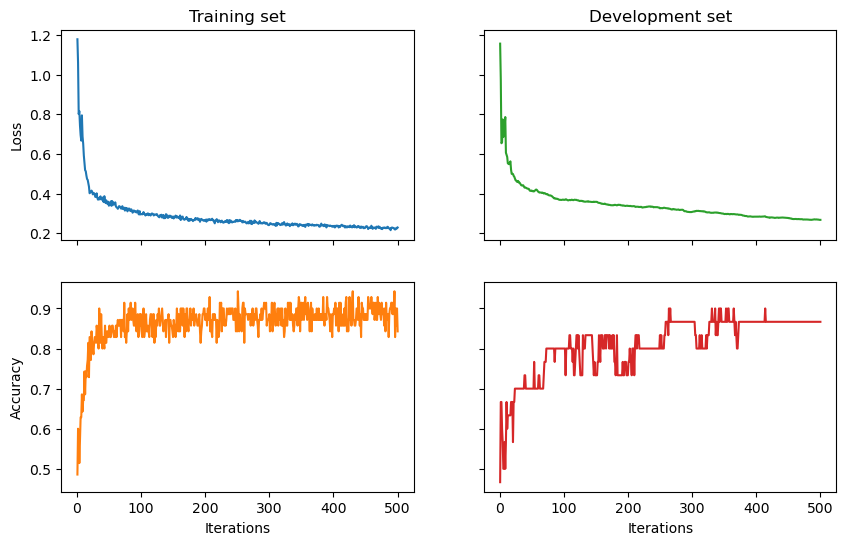

In [80]:
import matplotlib.pyplot as plt

trainer = trainerNumpy
model = modelNumpy
acc = accNP
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

# print test accuracy - tket
model.load(trainerTK.log_dir + '/best_model.lt')
val_acc = accTK(model(test_circuits), test_labels)
print('Validation accuracy:', val_acc.item())

test_loss = BinaryCrossEntropyLoss()
print('test: ')



In [86]:
# print(cohen_kappa_score(test_labels, test_labels))

model = modelPennylane

oneDimTestLabels = []
for label in test_labels: 
    if label[0] == 0: 
        oneDimTestLabels.append(0)
    else: 
        oneDimTestLabels.append(1)
    
oneDimPredictions = []
pred = model(test_circuits)
for label in pred: 
    if label[0] > label[1]: 
        oneDimPredictions.append(1)
    else: 
        oneDimPredictions.append(0)

print(oneDimPredictions, oneDimTestLabels)
print(cohen_kappa_score(oneDimTestLabels, oneDimPredictions))
print(f1_score(oneDimTestLabels, oneDimPredictions))



[1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1] [1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]
1.0
1.0


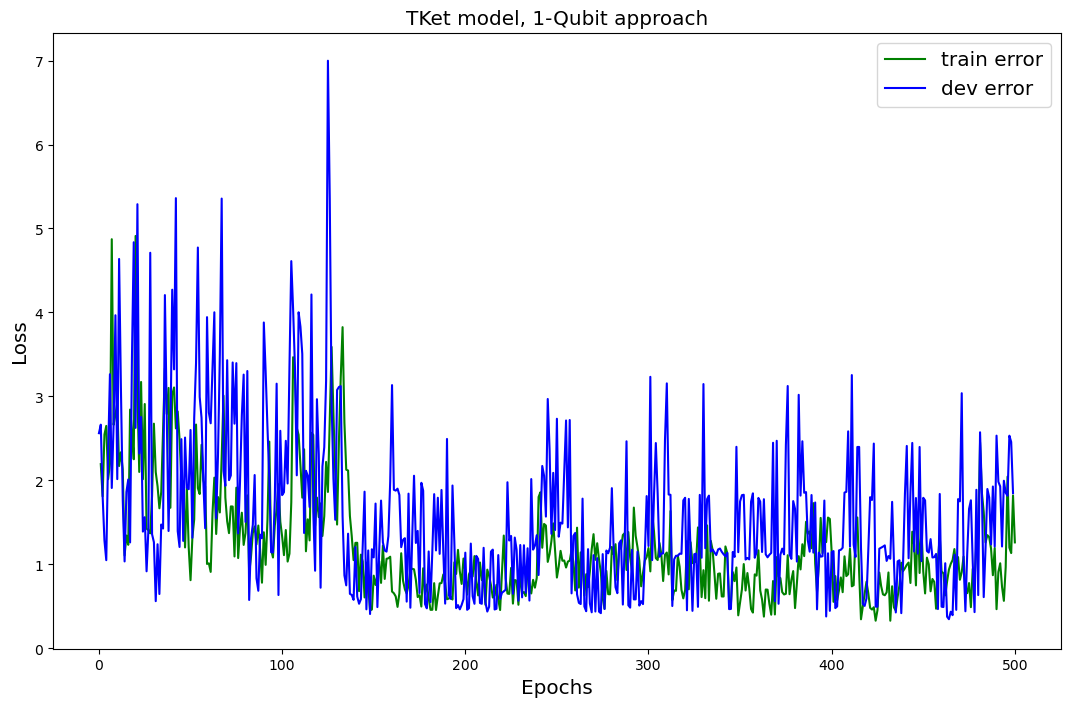

In [73]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(13, 8))

# ax1.plot(range_, trainer.train_epoch_costs, '-k', markersize=4, label='cost')
ax1.plot(range_, trainer.train_epoch_costs, '-g', markersize=4, label='train error')
ax1.plot(range(len(trainer.val_costs)), trainer.val_costs, '-b', markersize=4, label='dev error')
ax1.set_ylabel(r"Loss", fontsize='x-large')
ax1.set_xlabel(r"Epochs", fontsize='x-large')
# ax1.legend(loc='upper center', fontsize='x-large')

# ax2 = ax1.twinx()
# ax2.set_ylabel(r"Error in \%", fontsize='x-large')
# ax2.plot(range_, trainer.train_epoch_costs, '-g', markersize=4, label='train error')
# ax2.plot(range(len(trainer.val_costs)), trainer.val_costs, '-b', markersize=4, label='dev error')
# ax2.plot(range(len(trainer.train_costs)), trainer.train_costs, '-r', markersize=4, label='test error')
ax1.legend(loc='upper right', fontsize='x-large')


plt.title('TKet model, 1-Qubit approach', fontsize='x-large')
plt.savefig('MC_task_ECS_Results.png', dpi=300, facecolor='white')  
plt.show()


In [74]:
def BCL(y_true, y_pred):
    '''
    Binary Cross Entropy Loss
    '''
    result = 0
    for i in range(len(y_true)):
        result += ( y_true[i] * np.log(y_pred[i]) + (1-y_true[i]) * np.log(1- y_pred[i]) )

    return ( - 1 / (len(y_true)) * result )  

In [75]:
'''
manipulate labels a little, convert back to original, 1-dim labels
'''
yPredNew = []
yTrueNew = []

for i in range(len(pred)): 

    yPred = pred[i]
    yTrue = test_labels[i]

    # only prob for the positive class 
    if yPred[0] < 1e-15:
        yPredNew.append(yPred[0] + 1e-15)
    elif yPred[0] > (1-(1e-15)): 
        yPredNew.append(yPred[0] - 1e-15)
    else: 
        yPredNew.append(yPred[0])

    # true label 
    if yTrue[1] > yTrue[0]:
        yTrueNew.append(1)
    else:
        yTrueNew.append(0)

print(yPredNew)
print(yTrueNew)
        
    
rs = BCL(yTrueNew, yPredNew)
print(rs)


[1e-15, 1e-15, 0.25, 0.3888888888888889, 0.9473684210526315, 0.7777777777777778, 1e-15, 0.3157894736842105, 0.41935483870967744, 0.8888888888888888, 0.999999999999999, 0.18181818181818182, 1e-15, 0.9618320610687023, 0.9285714285714286, 1e-15, 0.10655737704918032, 0.3465346534653465, 0.06143344709897611, 0.4090909090909091, 0.17880794701986755, 0.9261744966442953, 0.9146341463414634, 0.999999999999999, 0.6, 0.999999999999999, 0.20512820512820512, 0.8471337579617835, 0.5882352941176471, 0.6]
[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
8.100116281332989


In [76]:
np.log(0.0000001)

-16.11809565095832